# Notas:
-  El 2 de julio de 2021 entró en operación una tienda de la competencia a pocos metros.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fase 1: Análisis Exploratorio Rápido (EDA Básico)

## 1. Carga y exploración inicial

In [2]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

In [3]:
print(demanda_df.head())
print("Dimensiones de los datos:", demanda_df.shape)

         date  id_producto  demanda
0  2020-01-01            3      869
1  2020-01-01            4      407
2  2020-01-01            5      182
3  2020-01-01            6       91
4  2020-01-01            7      520
Dimensiones de los datos: (126460, 3)


In [4]:
# Filtro de los datos del producto con id = 1
demanda_prod_df = demanda_df.loc[demanda_df['id_producto']==1,:]
demanda_prod_df.reset_index(inplace=True)
demanda_prod_df.drop(columns=['index'], inplace=True)
demanda_prod_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1010 non-null   object
 1   id_producto  1010 non-null   int64 
 2   demanda      1010 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.8+ KB


C:\Users\juanc\AppData\Local\Temp\ipykernel_28956\1124070411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df.drop(columns=['index'], inplace=True)


In [5]:
# Validacion de outliers
describe_df = demanda_prod_df.describe()
Q1 = describe_df.loc['25%','demanda']
Q3 = describe_df.loc['75%','demanda']
IQR = Q3 - Q1
outliers_df = demanda_prod_df[~demanda_prod_df['demanda'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]
print(describe_df, '\n')
print("Outliers considerando todos los datos")
outliers_df.head(100)

       id_producto      demanda
count       1010.0  1010.000000
mean           1.0    69.655446
std            0.0    23.458503
min            1.0    18.000000
25%            1.0    53.000000
50%            1.0    66.000000
75%            1.0    83.000000
max            1.0   183.000000 

Outliers considerando todos los datos


,date,id_producto,demanda
1,2020-01-03,1,140
3,2020-01-05,1,140
24,2020-01-31,1,137
108,2020-05-01,1,131
186,2020-07-19,1,132
325,2020-12-08,1,138
335,2020-12-18,1,130
336,2020-12-19,1,143
341,2020-12-25,1,177
346,2020-12-30,1,144


No hay datos faltantes en este caso.

## 2. Distribución de la variable objetivo (ventas del producto seleccionado)

In [6]:
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

C:\Users\juanc\AppData\Local\Temp\ipykernel_28956\2724779010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


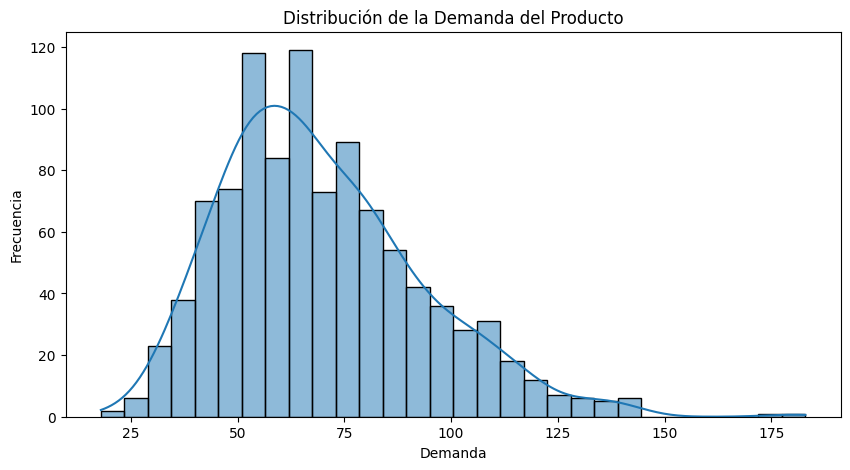

In [7]:
# Graficar el histograma de la columna 'demanda'
plt.figure(figsize=(10, 5))
sns.histplot(demanda_prod_df['demanda'], kde=True, bins=30)

# Añadir etiquetas y título
plt.xlabel('Demanda')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Demanda del Producto')

plt.show()

Los datos parecn seguir una distribucion normal pero aca estamos considerando datos de todos los meses ignorando eventualidades como la paricion de la tienda de la competencia.

**Insight:** la mejor manera de detectar outliers en una serie de tiempo es graficando el comportamiento mes a mes.

Verificaremos el insight separando datos tanto antes como despues.

In [8]:
# Ordenamiento por date
demanda_prod_df = demanda_prod_df.sort_values(by='date', ascending=True)
# Creacion de columnas de meses del anio
demanda_prod_df['mes'] = demanda_prod_df['date'].dt.month


# Datos previos a aparicion de tienda de competencia
demanda_antes_comp_df = demanda_prod_df[demanda_prod_df['date']<'2021-07-01']
# Datos desde que aparece de tienda de competencia
demanda_despues_comp_df = demanda_prod_df[demanda_prod_df['date']>='2021-07-01']

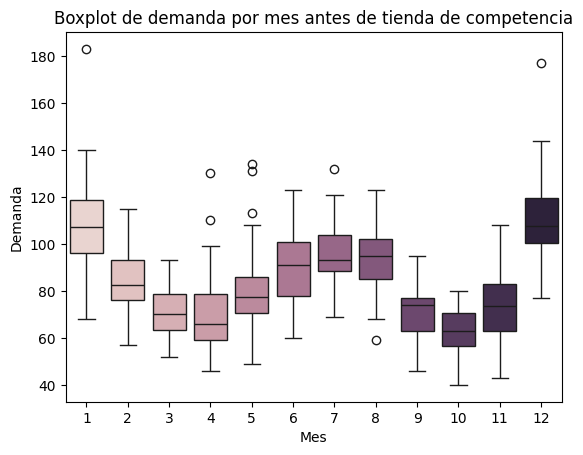

In [ ]:
# Grafica de distribucion de datos con seaborn
sns.boxplot(x='mes', y='demanda', data=demanda_antes_comp_df, hue='mes', legend=False)
plt.title('Boxplot de demanda por mes antes de tienda de competencia')
plt.xlabel('Mes')
plt.ylabel('Demanda')
plt.show()

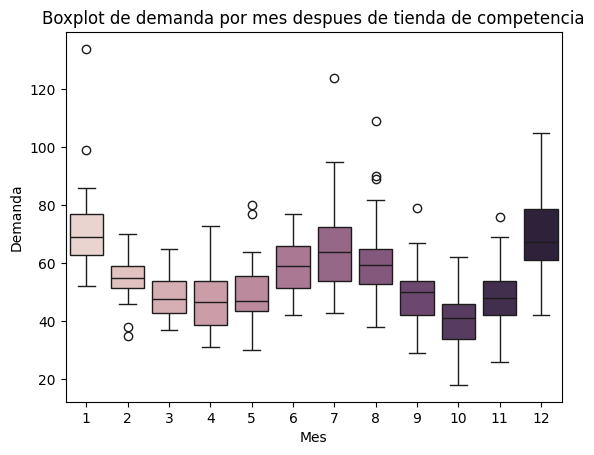

In [10]:
# Grafica de distribucion de datos con seaborn
sns.boxplot(x='mes', y='demanda', data=demanda_despues_comp_df, hue='mes', legend=False)
plt.title('Boxplot de demanda por mes despues de tienda de competencia')
plt.xlabel('Mes')
plt.ylabel('Demanda')
plt.show()

**Conclusion de outliers**

Siempre hay outliers superiores en enero y antes de junio (abril o mayo), lo que cambio es que antes de la tienda de la competencia se tenian dias atipicos superiores con muchas ventas entre abril y julio, mientras que despues de la llegada de la competencia, hay mas bien valores atipicos superiores entre julio y septiembre.


**Accion:** Si bien parece que el promedio de las ventas disminuyo con la llegada de la competencia, para el rango de ventas que se realizan desde entonces, se recomienda hacer mayor adquisicion del producto para los meses julio a septiembre para cubrir lo mejor posible la demanda atipica

# Fase 2: Análisis de Series de Tiempo

## 1. Visualización de la serie temporal

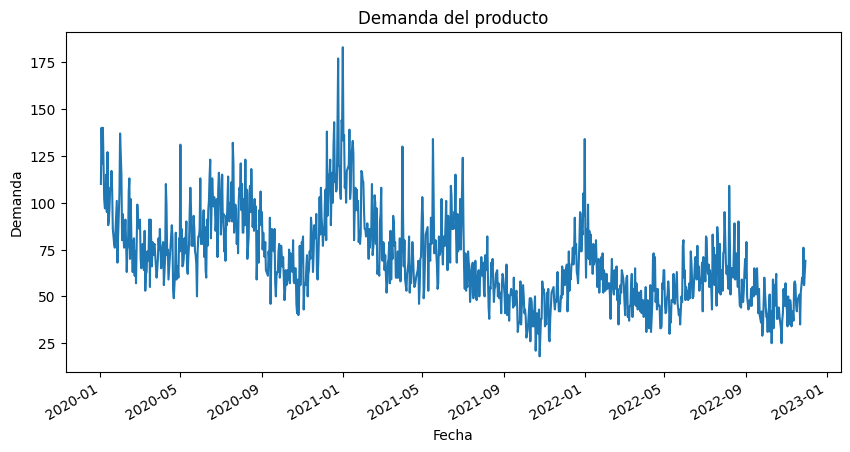

In [12]:
# Grafica de la variable objetivo:
plt.figure(figsize=(10,5))
plt.plot(demanda_prod_df['date'], demanda_prod_df['demanda'])

# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

# Rotar los x-ticks para mayor legibilidad
plt.gcf().autofmt_xdate()

plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title("Demanda del producto")

plt.show()

## 2. Detección de estacionalidad y tendencia

In [13]:
from statsmodels.tsa.seasonal import STL

**Elementos de una serie de tiempo $Y_t$ tras descomposicion:**
- Tendencia $T_t$
- Estacionalidad $S_t$
- Error $e_t$

**Tipo de descomposiciones:**
- **Aditiva**: Utiliza este modelo si los componentes de tendencia (T), estacionalidad (S) y ruido (e) son aproximadamente constantes en su amplitud a lo largo del tiempo.

Modelo: $Y_t = T_t + S_t + e_t$

- **Multiplicativa**: Utiliza este modelo si los componentes varían proporcionalmente con el nivel de la serie de tiempo. La estacionalidad y la tendencia multiplican la serie.

Modelo: $Y_t = T_t \times S_t \times e_t$

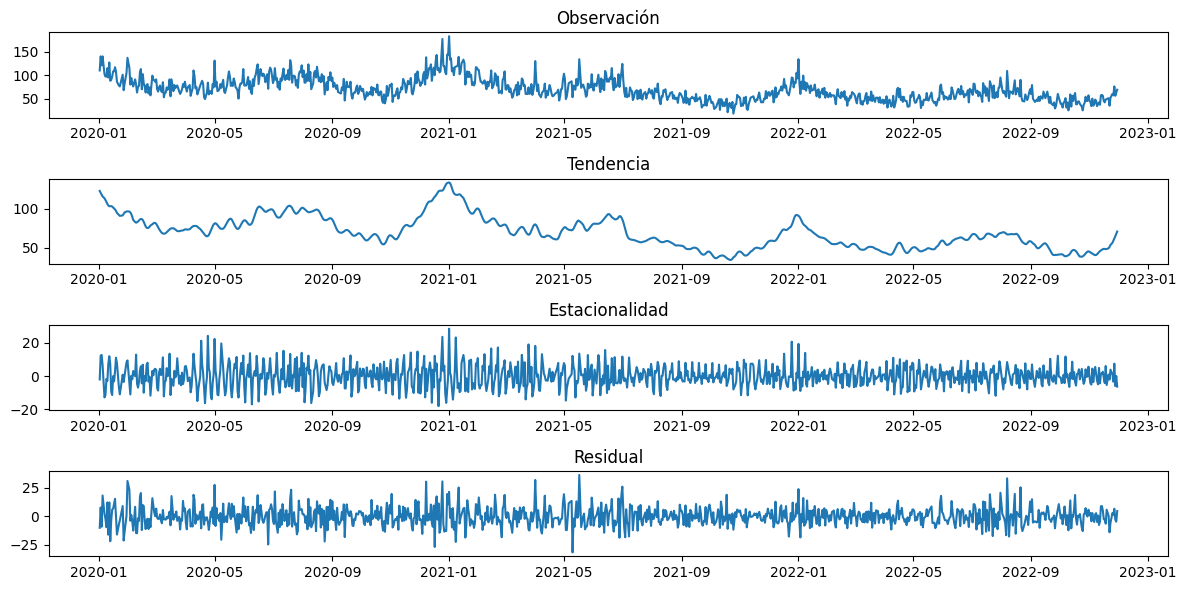

In [14]:
#decomposicion = seasonal_decompose(demanda_prod_df['demanda']
#                                   , model='additive'
#                                   , period=1365
#                                   )

stl = STL(demanda_prod_df['demanda'], period=7)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(demanda_prod_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(demanda_prod_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(demanda_prod_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(demanda_prod_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

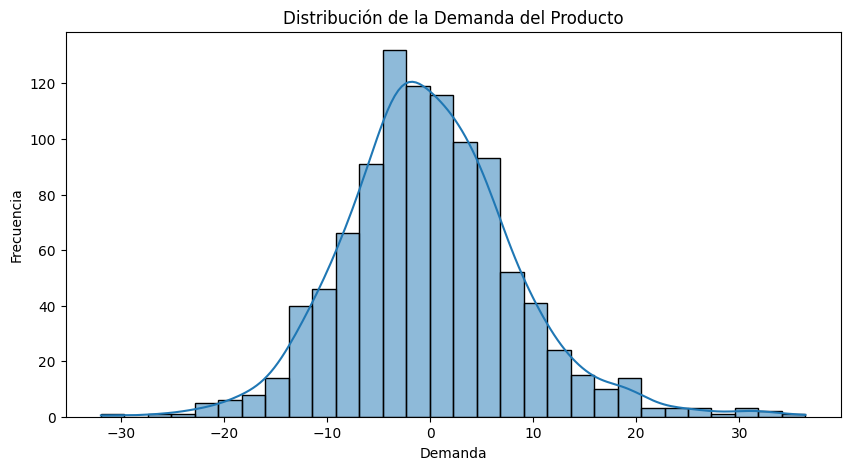

In [15]:
# Graficar el histograma de la columna 'demanda'
plt.figure(figsize=(10, 5))
sns.histplot(decomposicion.resid, kde=True, bins=30)

# Añadir etiquetas y título
plt.xlabel('Demanda')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Demanda del Producto')

plt.show()

- Tendencia decreciente: particularmente a lo largo de 2021, hay una aceleracion en la disminucion de las ventas.
- Residuales con media 0: no hay ningun sesgo sistematico en la descomposicion realizada.

## 3. Autocorrelación y patrones temporales

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

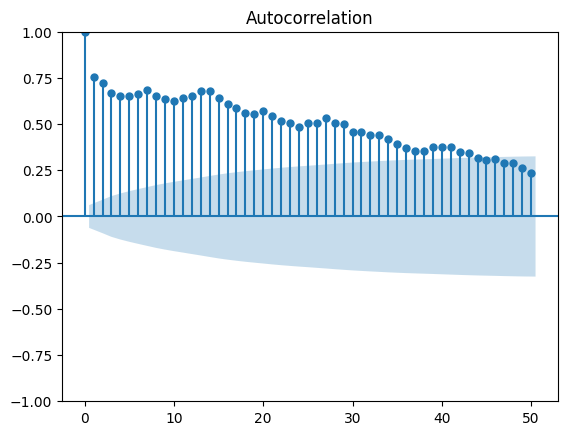

In [17]:
# Funcion de autocorrelacion (ACF): verifica dependencia de ventas pasadas en ventas futuras
plot_acf(demanda_prod_df['demanda'], lags=50)
plt.show()

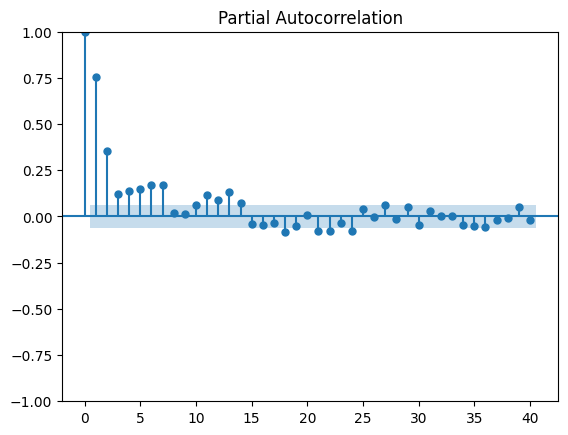

In [18]:
# Partial Autocorrelation Function (PACF): identifica que lags son relevantes
plot_pacf(demanda_prod_df['demanda'], lags=40)
plt.show()

## 4. Medias móviles y suavizado
**Proposito:**

In [27]:
ventana = 7
media_movil = demanda_prod_df['demanda'].rolling(window=ventana).mean()


C:\Users\juanc\AppData\Local\Temp\ipykernel_8292\3265628642.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


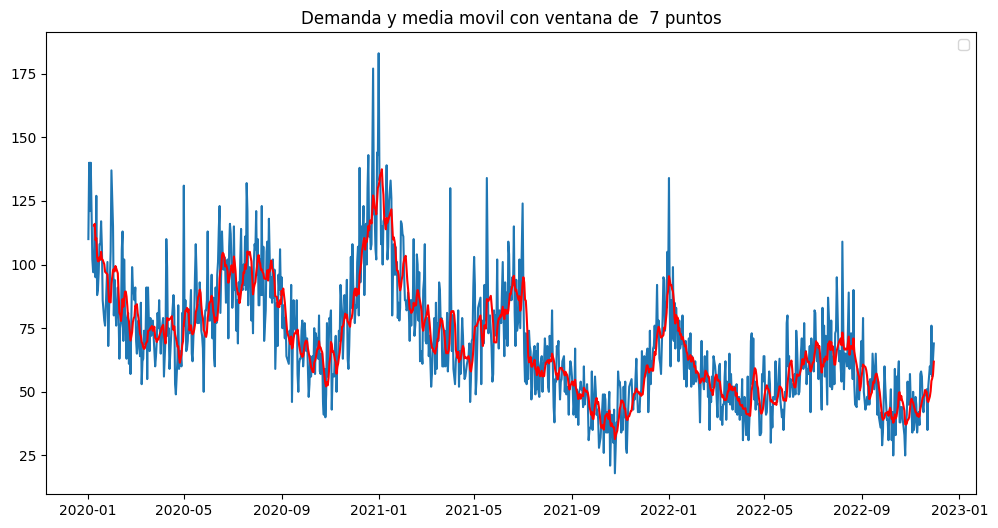

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(demanda_prod_df['date'], demanda_prod_df['demanda'])
plt.plot(demanda_prod_df['date'], media_movil, color='red')
plt.legend()
plt.title("Demanda y media movil con ventana de  {n} puntos".format(n=ventana))
plt.show()

# Fase 3: Evaluación del Impacto de la Nueva Tienda Competidora

## 1. Comparación antes/después del evento

In [21]:
# Calculo de promedio:
avg_antes = demanda_antes_comp_df['demanda'].mean()
avg_desp = demanda_despues_comp_df['demanda'].mean()

# Calculo de Desviacion estandar:
std_antes = demanda_antes_comp_df['demanda'].std()
std_desp = demanda_despues_comp_df['demanda'].std()

print("Promemdio de ventas antes:", avg_antes)
print("Promemdio de ventas despues:", avg_desp, '\n')

print("Cambio en % de promedio de ventas:", abs((avg_desp - avg_antes)/avg_antes)*100, '\n')

print("Std. de ventas antes:", std_antes)
print("Std. de ventas despues:", std_desp)

Promemdio de ventas antes: 83.98255813953489
Promemdio de ventas despues: 54.69028340080972 

Cambio en % de promedio de ventas: 34.87899795819127 

Std. de ventas antes: 21.153385417191824
Std. de ventas despues: 14.818551866923626


Con la media vemos que hubo un impacto significativo con las ventas, disminuyendo el promedio de ventas en un 34,9%

## 2. Prueba de impacto estadístico

In [22]:
from scipy import stats

P-valor Shapiro-Wilk antes: 6.207608593850821e-10
P-valor Shapiro-Wilk después: 2.4933759200826803e-10
P-valor Levene: 3.8260087263122455e-12


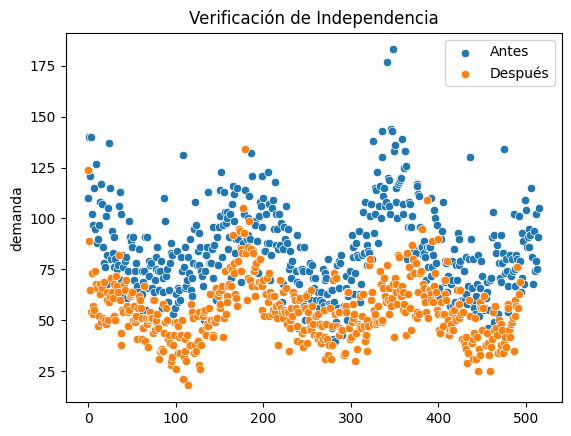

T-statistic: 25.38644158435868
P-value: 2.5614838788233974e-110


In [23]:
# Datos de ejemplo
ventas_antes = demanda_antes_comp_df['demanda']
ventas_despues = demanda_despues_comp_df['demanda']

# Verificar normalidad con la prueba de Shapiro-Wilk
shapiro_test_antes = stats.shapiro(ventas_antes)
shapiro_test_despues = stats.shapiro(ventas_despues)
print(f'P-valor Shapiro-Wilk antes: {shapiro_test_antes.pvalue}')
print(f'P-valor Shapiro-Wilk después: {shapiro_test_despues.pvalue}')

# Verificar homogeneidad de varianzas con la prueba de Levene
levene_test = stats.levene(ventas_antes, ventas_despues)
print(f'P-valor Levene: {levene_test.pvalue}')

# Verificar independecia visualmente (gráfico de dispersión)
sns.scatterplot(x=np.arange(len(ventas_antes)), y=ventas_antes, label='Antes')
sns.scatterplot(x=np.arange(len(ventas_despues)), y=ventas_despues, label='Después')
plt.legend()
plt.title('Verificación de Independencia')
plt.show()

# Realizar el t-test
t_stat, p_value = stats.ttest_ind(ventas_antes, ventas_despues)
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')


In [24]:
demanda_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         1010 non-null   datetime64[ns]
 1   id_producto  1010 non-null   int64         
 2   demanda      1010 non-null   int64         
 3   mes          1010 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(2)
memory usage: 27.7 KB


In [25]:
def marcar_antes_despues_competencia(row):
    if row['date'] < pd.Timestamp('2021-07-01'):
        return 'Antes de tienda de competencia'
    else:
        return 'Despues de tienda de competencia'
demanda_prod_df['Dataset'] = demanda_prod_df.apply(marcar_antes_despues_competencia, axis=1)

Text(0.5, 1.0, 'Grafica de Densidad de datos antes / despues de tienda de competencia')

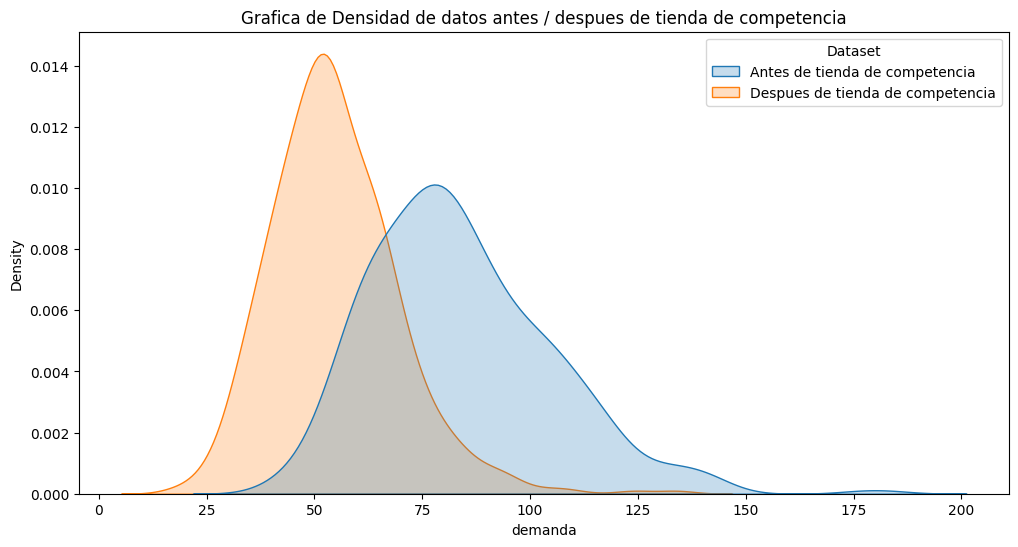

In [26]:
# Grafica final de densidad de poblacional
plt.figure(figsize=(12, 6))
sns.kdeplot(data=demanda_prod_df, x='demanda', hue='Dataset', fill=True)
plt.title("Grafica de Densidad de datos antes / despues de tienda de competencia")

# Conclusion:
- Para validar si hubo un impacto, el calculo rapido de diferencia de porcentages da una primera idea del impacto con las medias
- Con pruebas estadisticas como el T-Test se puede confirmar si estadisticamente hay una diferencia entre las poblaciones. Esta prueba tiene los supuestos que la distribucion de ambas muestras es normal. 

    1. Si hay pocos datos (< 30) se usa el t-test y se desconoce la varianza poblacional, se hace el T-Test tradicional
    2. Si hay bastantes datos (>=30) y **se conocen las varianzas poblacionales (no las muestrales)**, se puede hacer un Z-test.
    3. En los casos 1 y 2 anteriores, se asume que la varianza es la misma entre ambas muestras. Si la varianza es diferente como suele suceder, se usa el **T-Test de Welch**.

En cualquier caso, se obtiene un p-valor, y si es menor a 0.05 hay suficiente evidencia estadistica para rechazar H0: las poblaciones son diferentes. 